<a href="https://colab.research.google.com/github/lustea0201/Interpretability/blob/master/Interpretation4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting the outputs of the model on the fourth dataset

We first need to load the dataset. 

In [1]:
#@title
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive/')

!pip install flashtorch
from flashtorch.saliency import Backprop

!pip install shap 
import shap

!pip install pytorch-gradcam
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

!wget https://raw.githubusercontent.com/yiskw713/SmoothGradCAMplusplus/master/cam.py -P local_modules -nc
!wget https://raw.githubusercontent.com/yiskw713/SmoothGradCAMplusplus/master/utils/visualize.py -P local_modules -nc
import sys
sys.path.append('local_modules')
from PIL import Image
from local_modules.visualize import visualize
import local_modules.cam as smooth

!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/HierarchicalShapley.py -P local_modules -nc
import local_modules.HierarchicalShapley as HS

!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/utils.py -P local_modules -nc
import local_modules.utils as utils

!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/interpret11.py -P local_modules -nc
import local_modules.interpret11 as intp

torch.manual_seed(0)

dtype = torch.float

FIGSIZE = (5,4)

net = utils.Net() # Model instantiation
# Loading the trained dictionnary state
net.load_state_dict(torch.load('drive/My Drive/Interpretability/model4.pth')) 

data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/5000/data4/data.zip", 'r')

root_dir = "main_dir"
data.extractall(root_dir)
data.close()

Batch_Size = 64
MEAN, STD = np.array([0.5, 0.5, 0.5]), np.array([0.5, 0.5, 0.5])

transf = transforms.Compose( [ToTensor(), Normalize(mean=MEAN, std=STD)])

train_data = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf)
dataloader = DataLoader(train_data, batch_size = Batch_Size, shuffle = False, num_workers = 0)
train_loader = iter(dataloader)


ImF = ImageFolder(root = "/content/drive/My Drive/Interpretability/img4saliencymap/data4", transform = transf)
batch_Size = 3
exloader = DataLoader(ImF, batch_size = batch_Size, shuffle = False, num_workers = 0)

exIter = iter(exloader)
images, labels = next(exIter)

# For guided backprop
backprop = Backprop(net)

# For SHAP
X,Y = next(train_loader)
bg_choice = None # Default: entire training set, "average", "white", "black" 
# Median would result in white 
background = X
if (bg_choice == "black"): 
  background = -torch.ones(X.shape)
elif (bg_choice == "white"): 
  background = torch.ones(X.shape)
elif (bg_choice == "average"): 
  avg = torch.mean(X, dim = 0)
  display_image(avg, 0)
e = shap.GradientExplainer(net, background)

# For GradCAM
gradcam_conv = GradCAM(net, net.conv2)
gradcam_pp_conv = GradCAMpp(net, net.conv2)
gradcam_pool = GradCAM(net, net.pool2)
gradcam_pp_pool = GradCAMpp(net, net.pool2)

# For SmoothCAM
target_layer = net.conv2
wrapped_G = smooth.GradCAM(net, target_layer)
wrapped_P = smooth.GradCAMpp(net, target_layer)
wrapped_S = smooth.SmoothGradCAMpp(net, target_layer, n_samples=25, stdev_spread=0.15)
wrapped = [wrapped_G, wrapped_P, wrapped_S]

# For Hierarchical Shapley
average = torch.mean(X, dim = 0)
h = HS.HierarchicalShap(net, background = average)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
  Created wheel for flashtorch: filename=flashtorch-0.1.2-cp36-none-any.whl size=26236 sha256=3adae6cd3291f2b9b56c224c5c780a6dfc44309a2e1f12ced44dbc7a73bb4585
  Stored in directory: /root/.cache/pip/wheels/91/44/8e/c33cc10ab8d0f24036e82f0e475277dc4a479cd3fb03329a39
Successfully built flashtorch
     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394116 sha256=442df63ee1eae74a14

For this dataset, we should import two images with label 0, because a label 0 can be attributed for two different reasons: 
- absence of a black circle 
- presence of a cross 

Let's first do one with crosses. 
# EXAMPLE 0

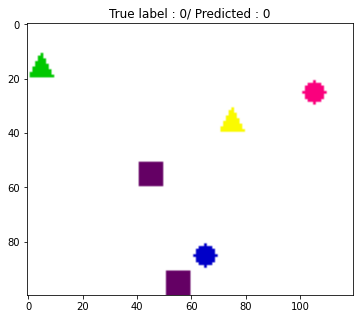

In [2]:
image0 = images[0]
label0 = labels[0]

input0 = image0.view(-1, 3, 100, 120) # This shape is necessary for the network 
output0 = net(input0)
_, predicted0 = torch.max(output0.data, 1)

img0 = utils.input2image(image0, MEAN, STD)
utils.display_image(img0, label0.numpy(), int(predicted0))

This image was correctly labeled as a 0, because it contains crosses (even though there is a black circle). 

What parts in the input were considered important by the network to make this call ? 
### Guided backpropagation explanation

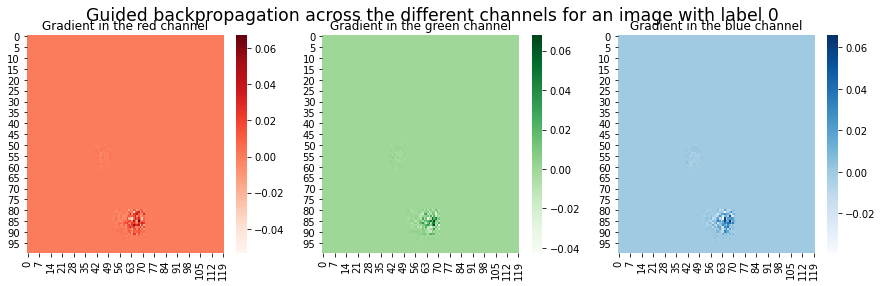

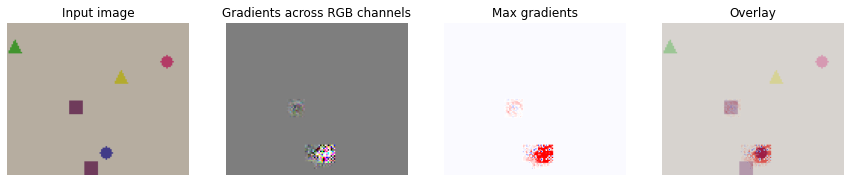

In [3]:
input0.requires_grad = True # Necessary to compute the gradient
gradients0 = backprop.calculate_gradients(input0, label0, guided = True).detach().numpy()
intp.display_gradients(gradients0, FIGSIZE).suptitle("Guided backpropagation across the different channels for an image with label 0", size="xx-large");
backprop.visualize(input0, label0, guided=True, figsize = (3*FIGSIZE[0], FIGSIZE[1]), cmap="bwr")

### Shapley explanation

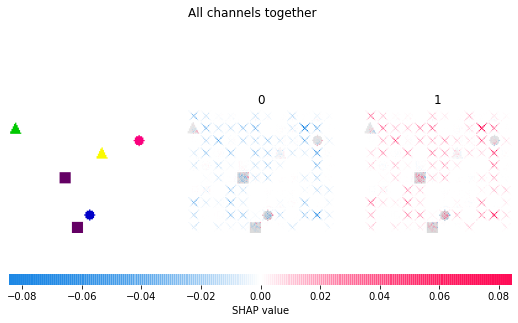

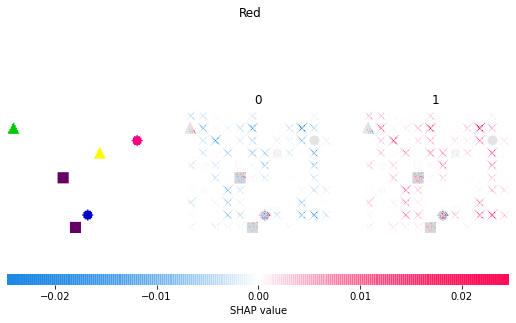

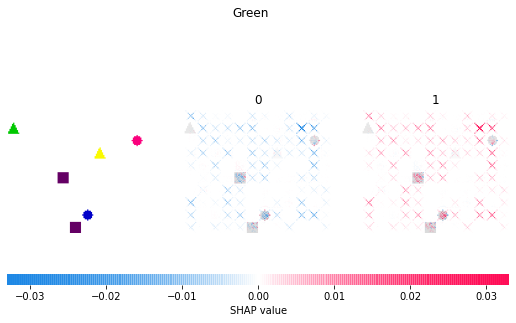

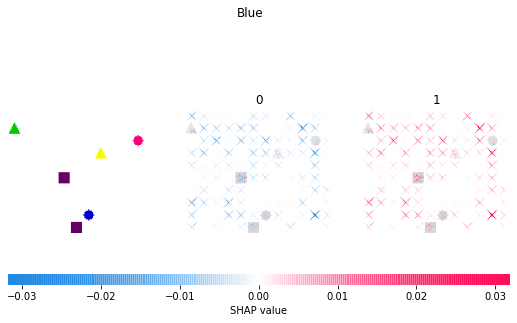

In [4]:
intp.shap_exp(e, input0.detach(), img0)

### GradCAM explanation

nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


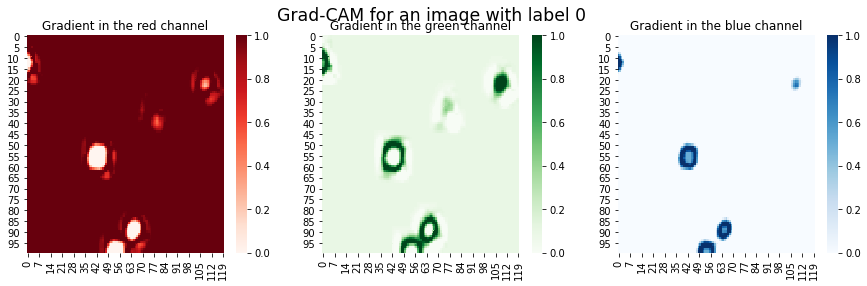

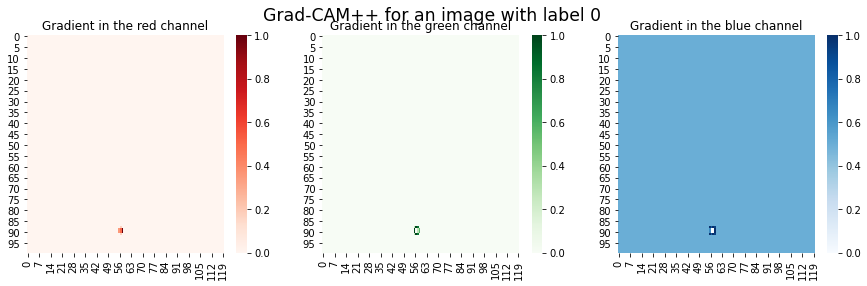

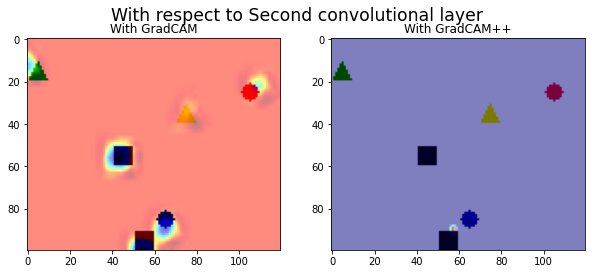

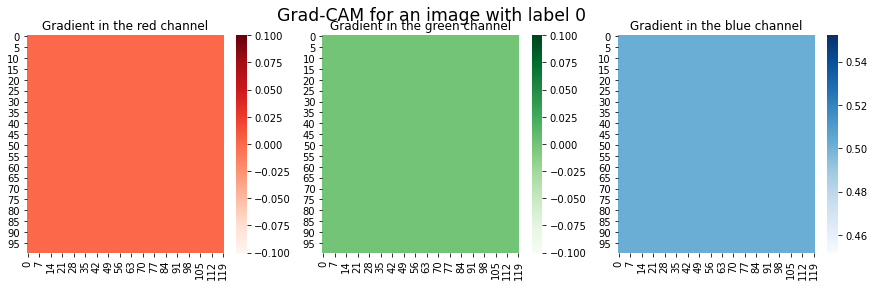

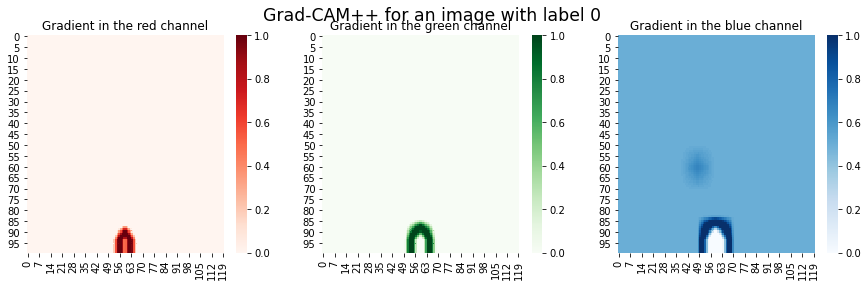

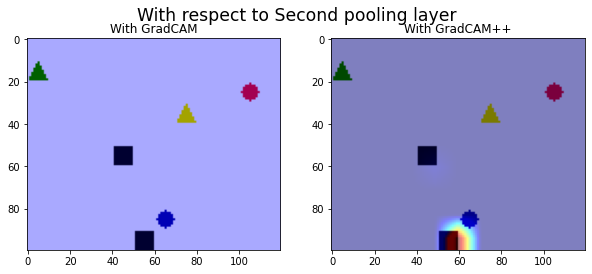

In [5]:
intp.gradcam_exp(gradcam_conv, gradcam_pp_conv, input0, img0,  "Second convolutional layer", FIGSIZE)
intp.gradcam_exp(gradcam_pool, gradcam_pp_pool, input0, img0,  "Second pooling layer", FIGSIZE)

### SmoothCAM explanation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class ids 0	 probability 0.9994319081306458
predicted class ids 0	 probability 0.9994319081306458


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class ids 0	 probability 0.9994133710861206


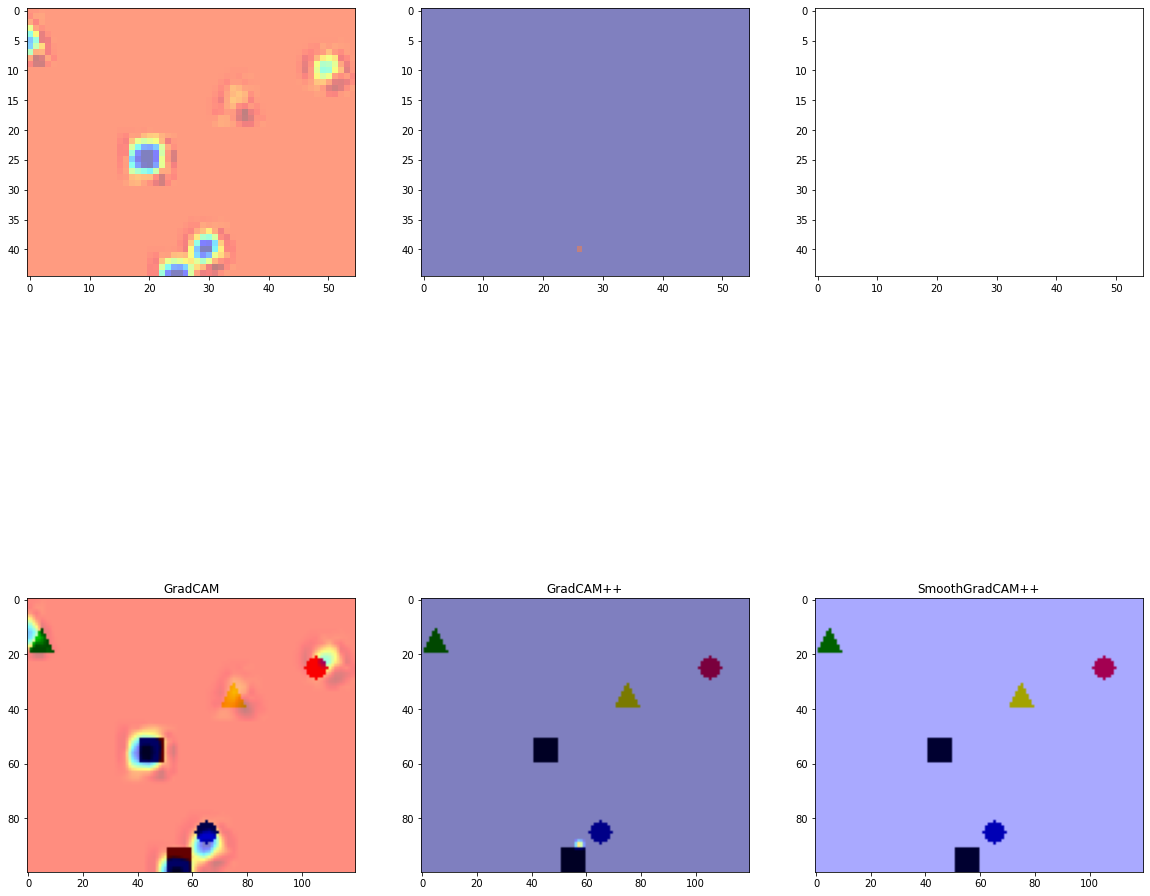

In [6]:
intp.smooth_exp(input0, image0, wrapped)

### Hierarchical Shapley explanation

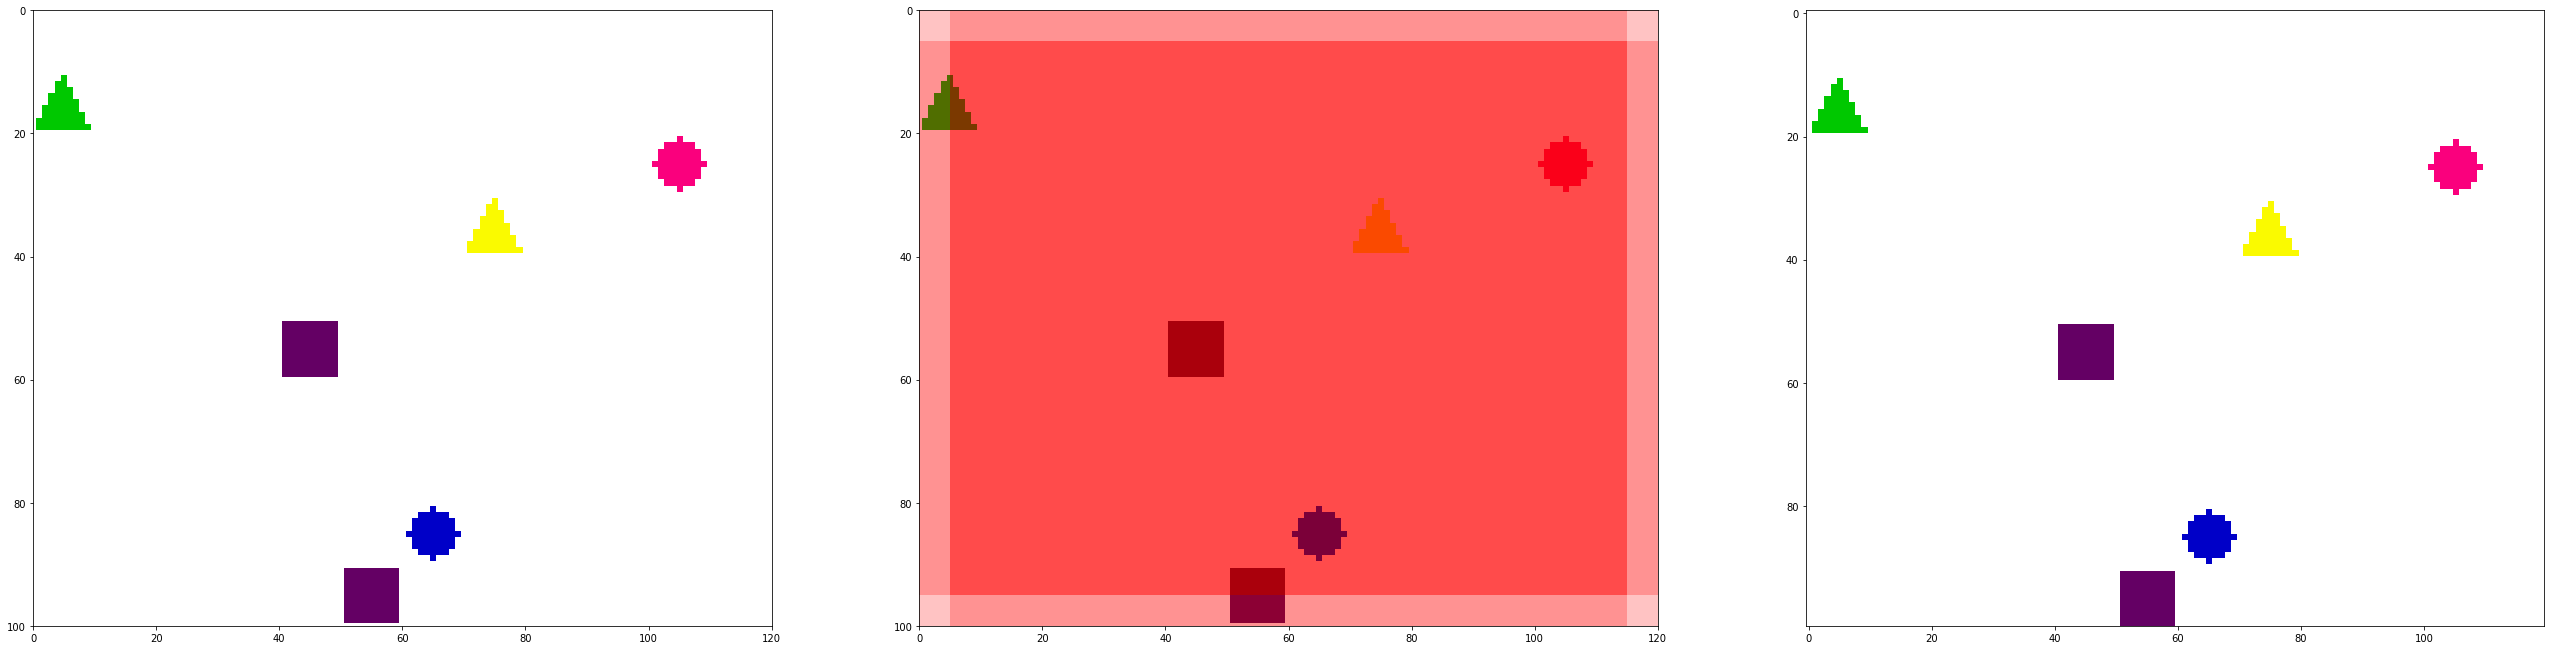

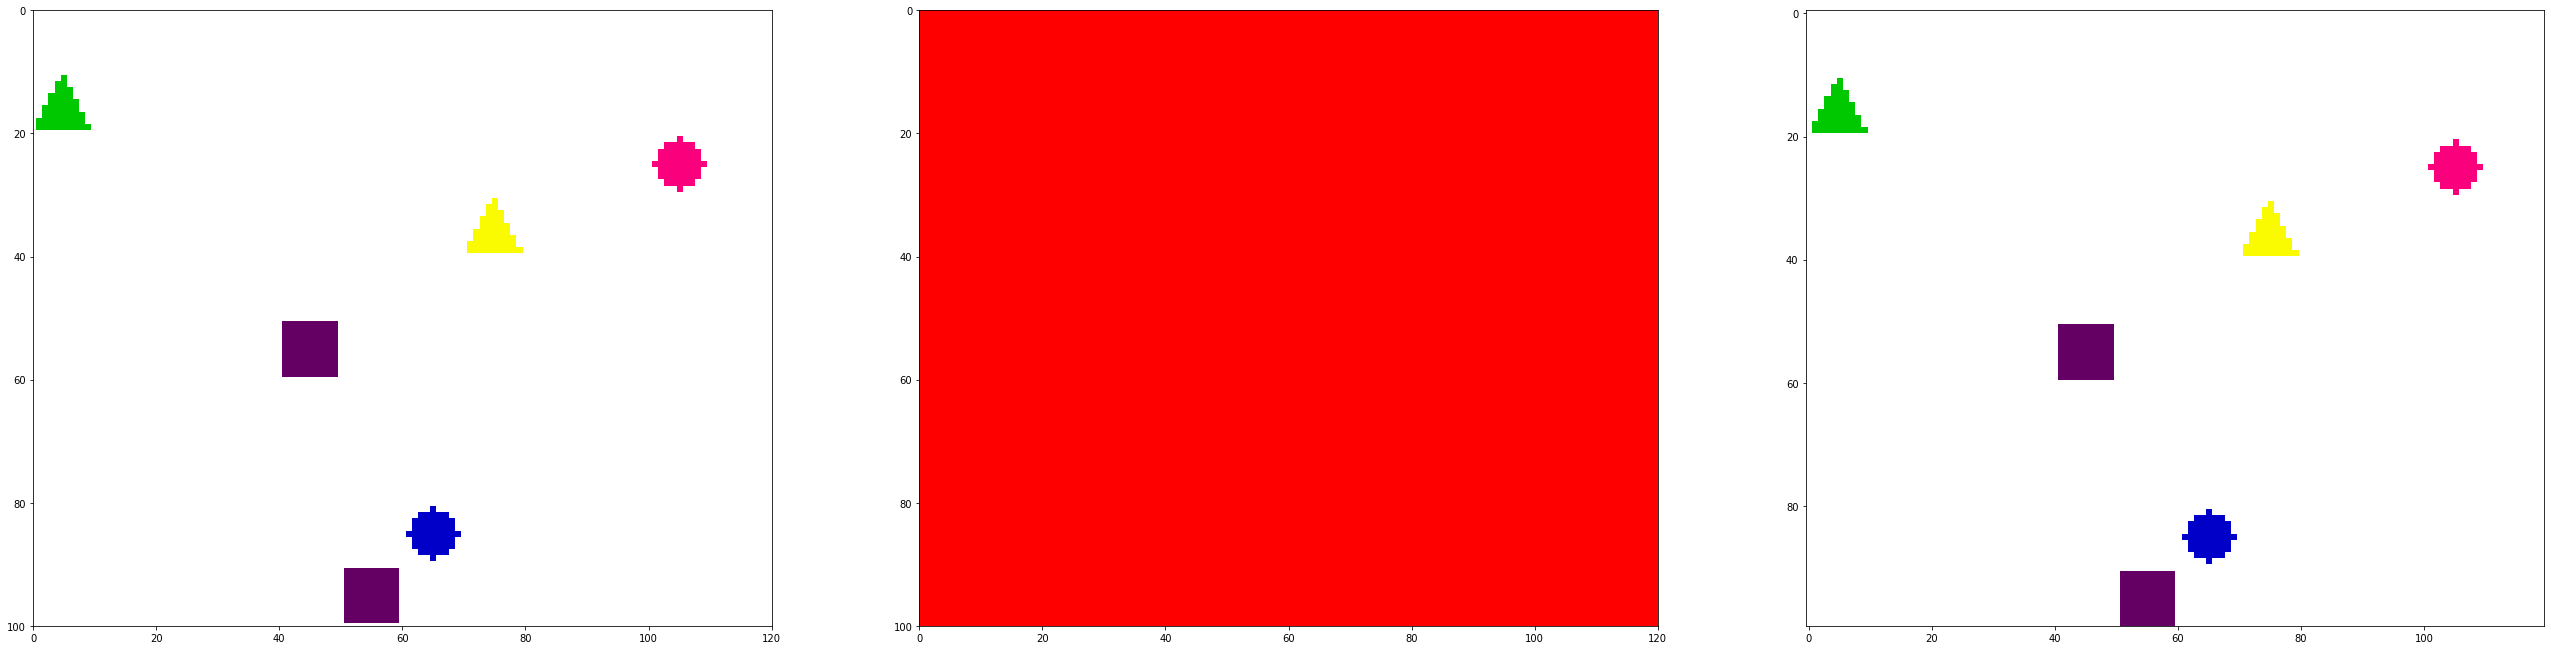

In [7]:
h.saliency_map(image0, label0, tolerance = [5,5.5,6,6.5,7], only_one_run = False);
h.saliency_map(image0, label0, tolerance = [6], only_one_run = True);

# EXAMPLE 1

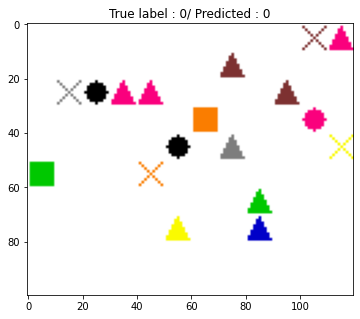

In [8]:
image1 = images[1]
label1 = labels[1]

input1 = image1.view(-1, 3, 100, 120)
output1 = net(input1)
_, predicted1 = torch.max(output1.data, 1)

img1 = utils.input2image(image1, MEAN, STD)
utils.display_image(img1, label1.numpy(), int(predicted1))

### Backpropagation

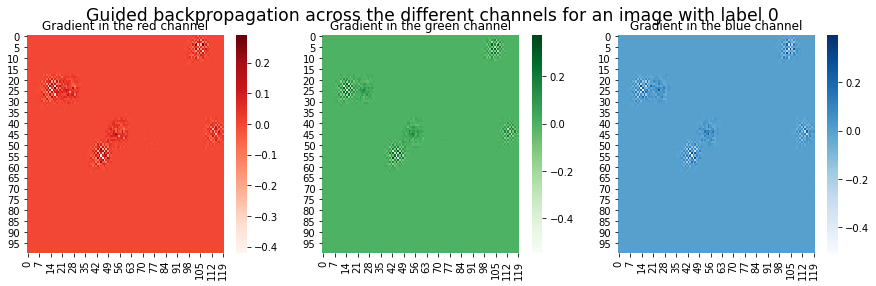

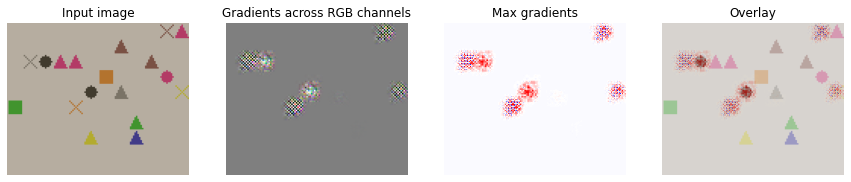

In [9]:
input1.requires_grad = True # Necessary to compute the gradient
gradients1 = backprop.calculate_gradients(input1, label1, guided = True).detach().numpy()
intp.display_gradients(gradients1, FIGSIZE).suptitle("Guided backpropagation across the different channels for an image with label 0", size="xx-large");
backprop.visualize(input1, label1, guided=True, figsize = (3*FIGSIZE[0], FIGSIZE[1]), cmap="bwr")

### Shapley explanation

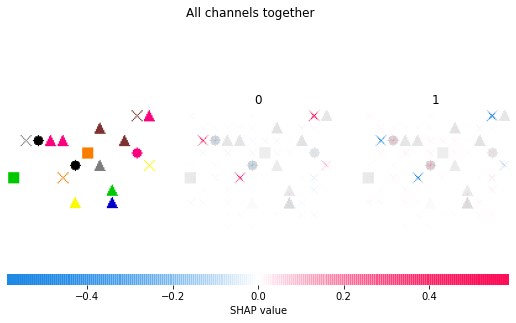

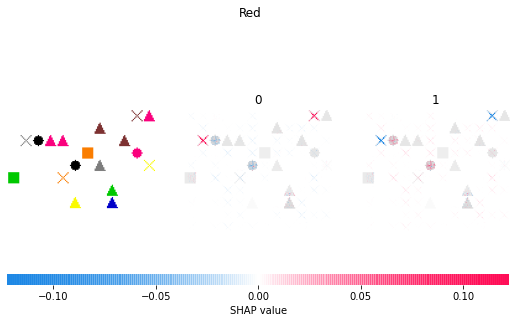

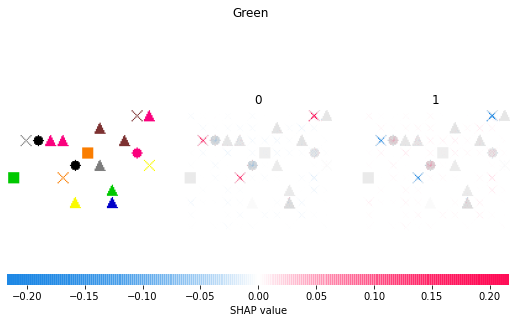

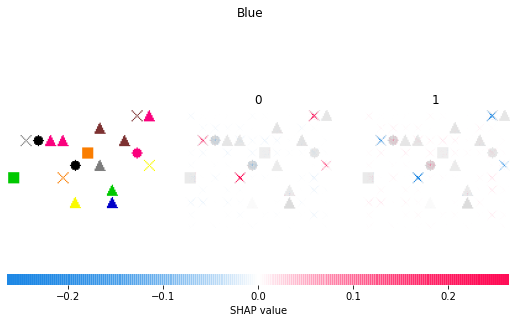

In [10]:
intp.shap_exp(e, input1.detach(), img1)

### GradCAM

nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


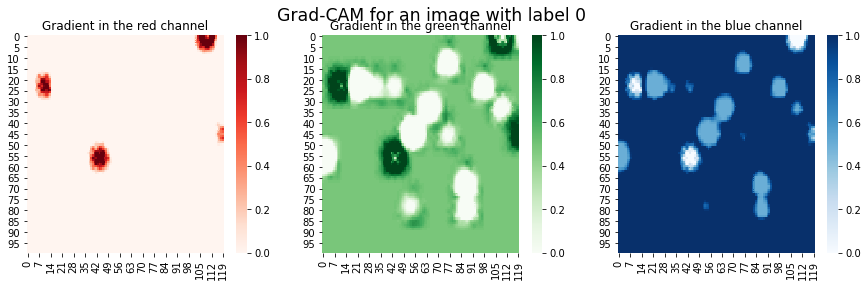

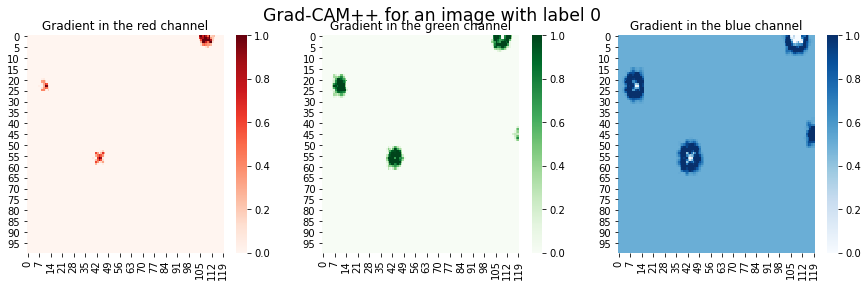

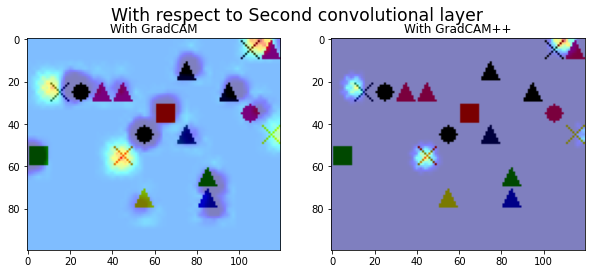

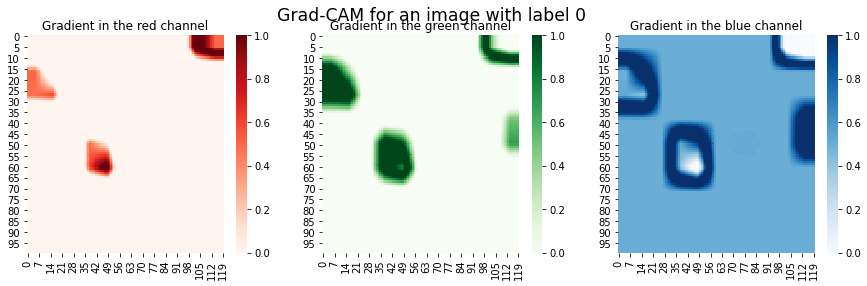

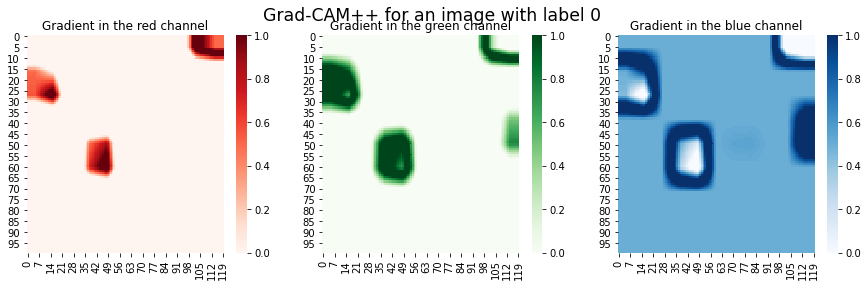

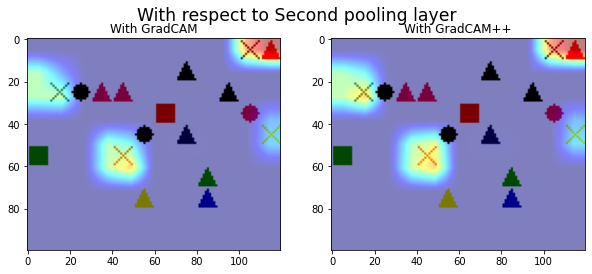

In [11]:
intp.gradcam_exp(gradcam_conv, gradcam_pp_conv, input1, img1,  "Second convolutional layer", FIGSIZE)
intp.gradcam_exp(gradcam_pool, gradcam_pp_pool, input1, img1,  "Second pooling layer", FIGSIZE)

### SmoothCAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class ids 0	 probability 1.0
predicted class ids 0	 probability 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class ids 0	 probability 1.0


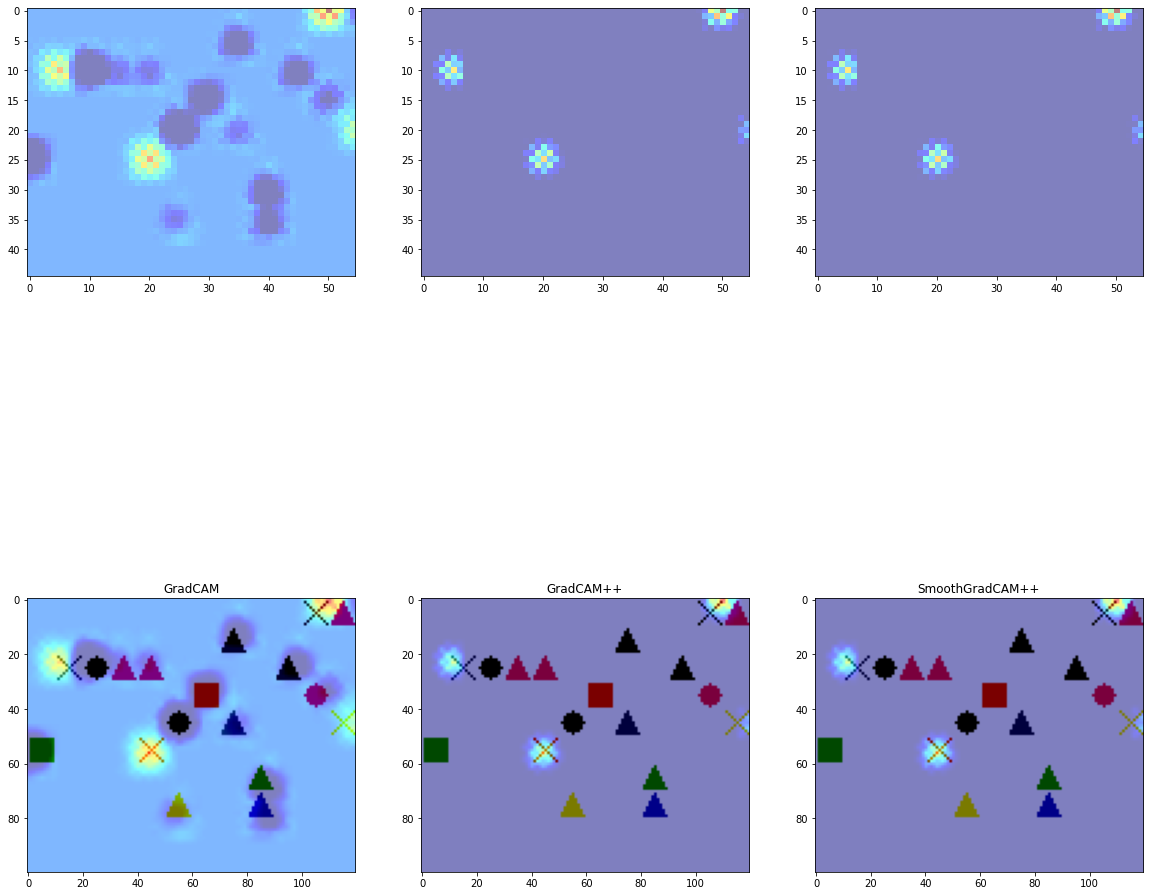

In [12]:
intp.smooth_exp(input1, image1, wrapped)

### Hierarchical Shapley

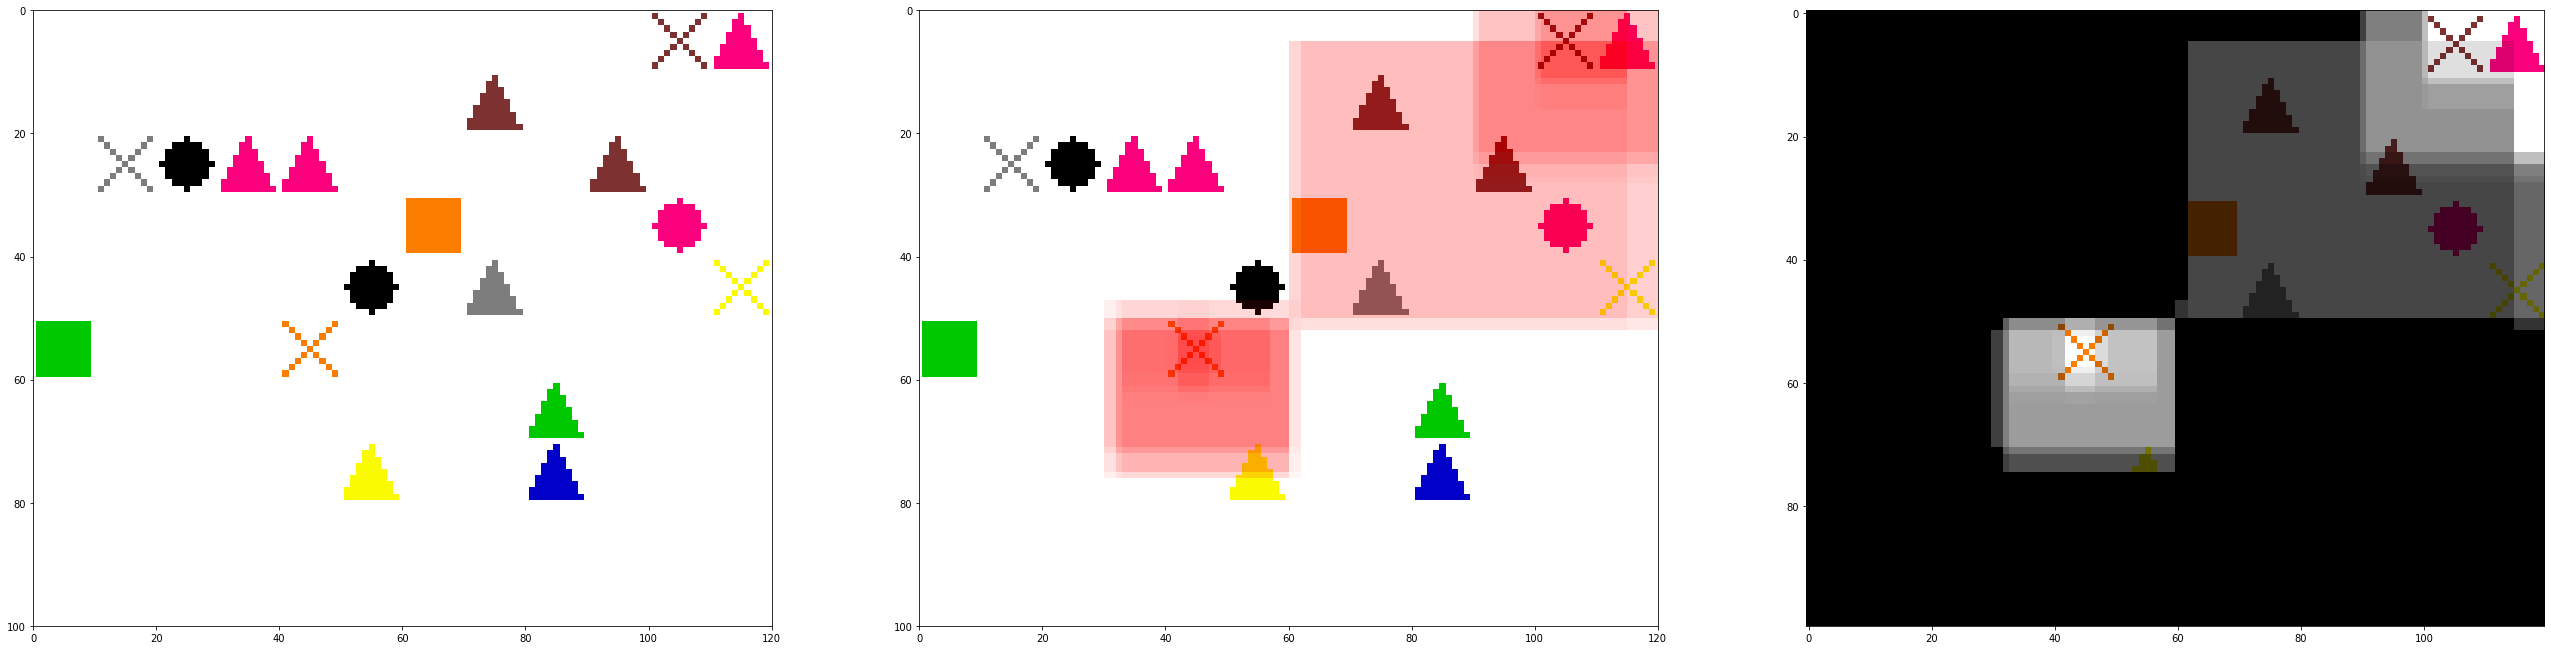

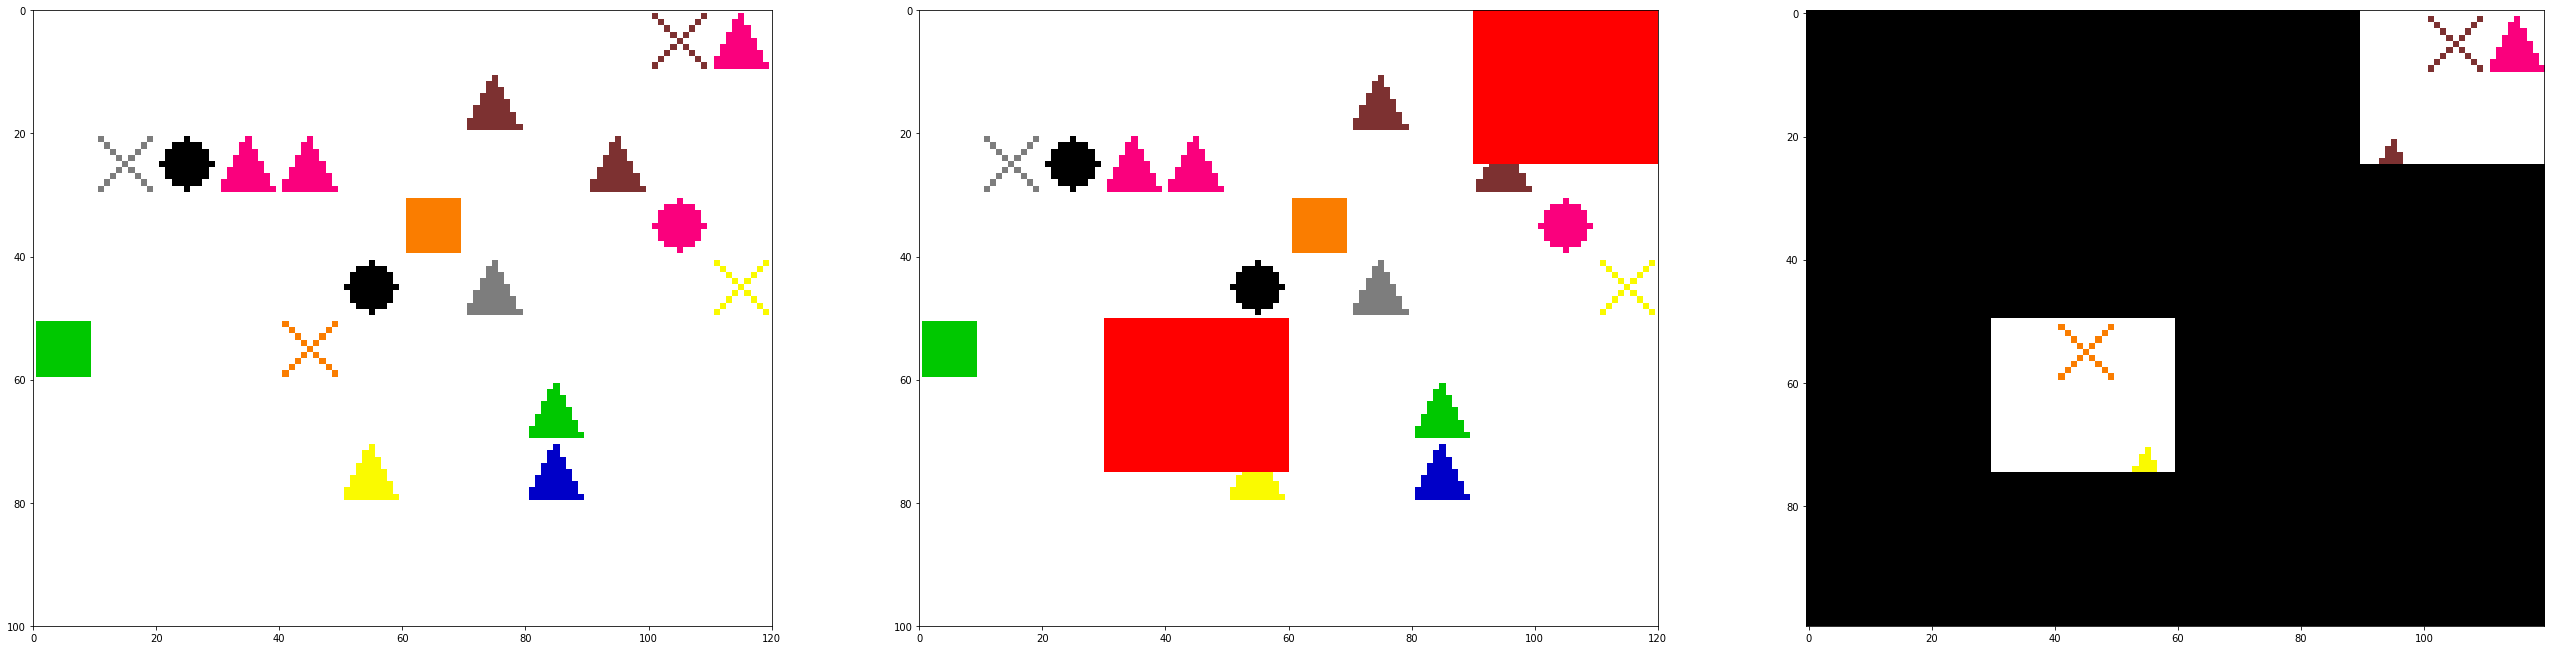

In [13]:
h.saliency_map(image1, label1, tolerance = [5,5.5,6,6.5,7], only_one_run = False);
h.saliency_map(image1, label1, tolerance = [6], only_one_run = True);

# EXAMPLE 2

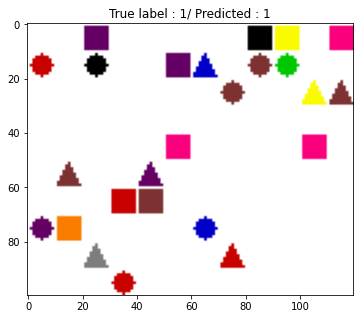

In [14]:
image2 = images[2]
label2 = labels[2]

input2 = image2.view(-1, 3, 100, 120)
output2 = net(input2)
_, predicted2 = torch.max(output2.data, 1)

img2 = utils.input2image(image2, MEAN, STD)
utils.display_image(img2, label2.numpy(), int(predicted2))

This image was correctly labeled as a 1, because it contains a black circle but no crosses.
## Guided backpropagation

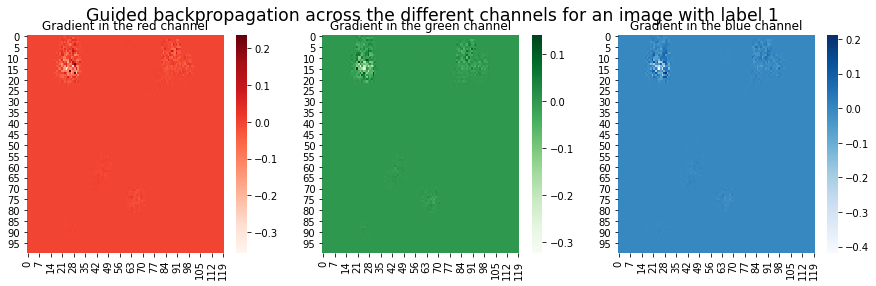

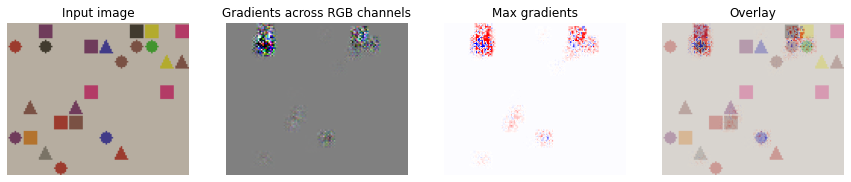

In [15]:
input2.requires_grad = True # Necessary to compute the gradient
gradients2 = backprop.calculate_gradients(input2, label2, guided = True).detach().numpy()
intp.display_gradients(gradients2, FIGSIZE).suptitle("Guided backpropagation across the different channels for an image with label 1", size="xx-large");
backprop.visualize(input2, label2, guided=True, figsize = (3*FIGSIZE[0], FIGSIZE[1]), cmap="bwr")

## Shap 

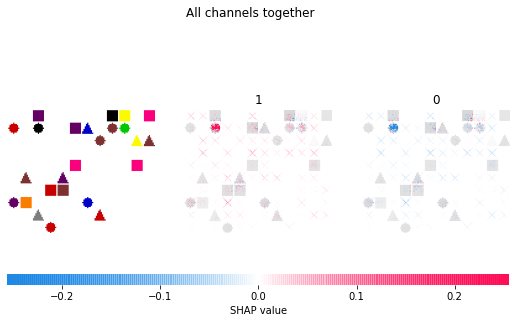

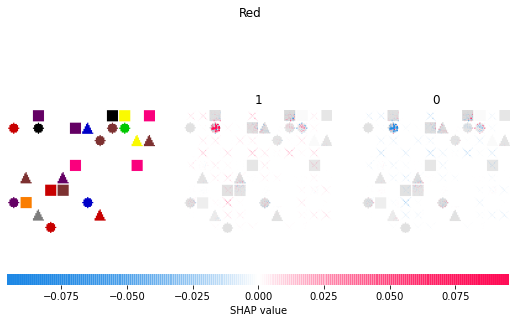

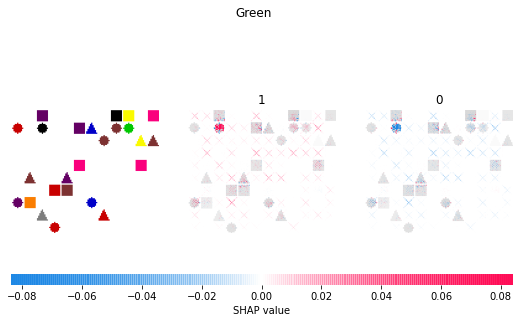

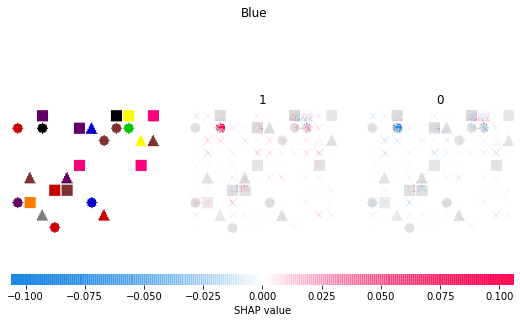

In [16]:
intp.shap_exp(e, input2.detach(), img2)

## GradCAM

nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


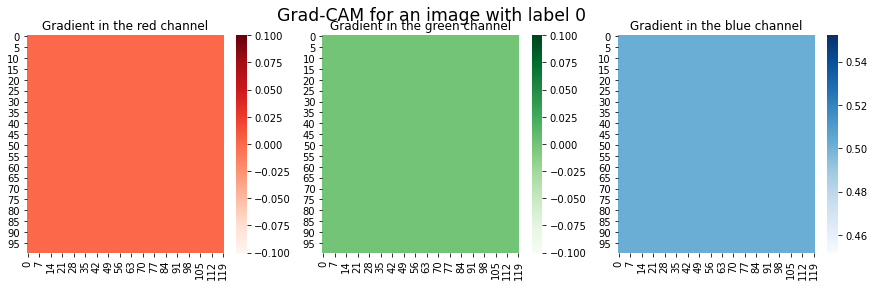

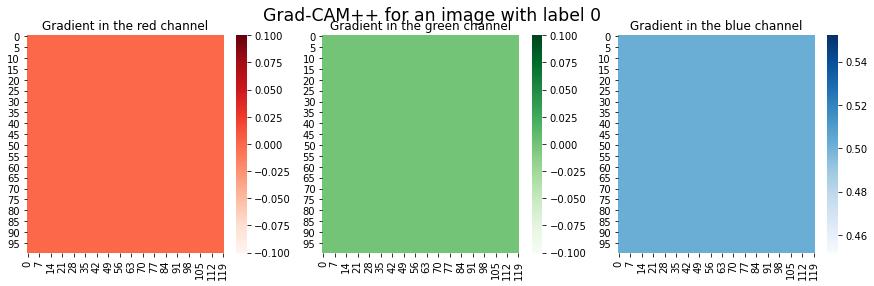

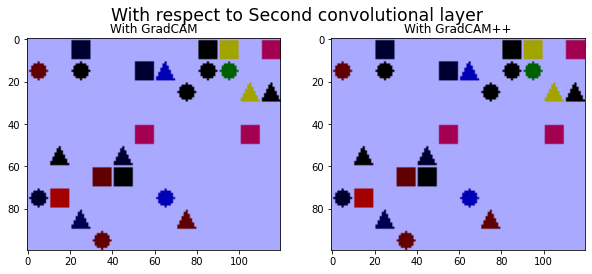

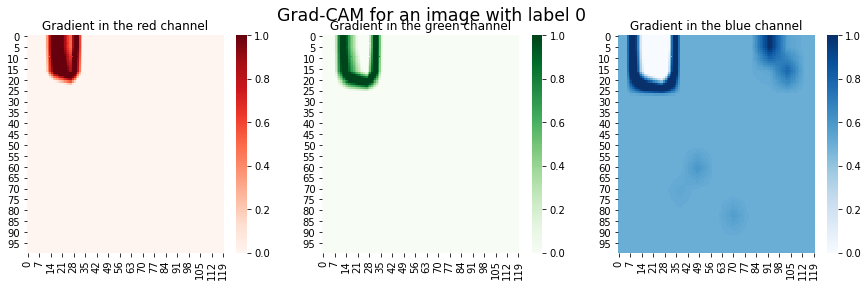

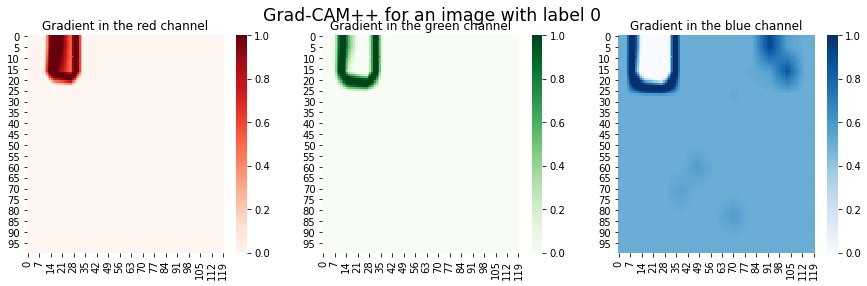

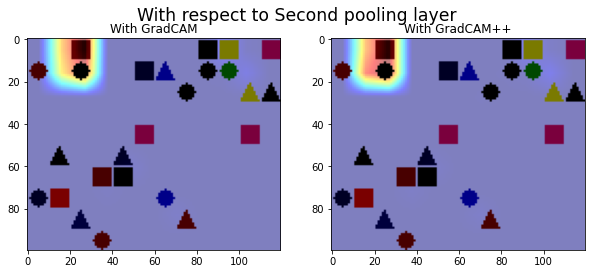

In [17]:
intp.gradcam_exp(gradcam_conv, gradcam_pp_conv, input2, img2,  "Second convolutional layer", FIGSIZE)
intp.gradcam_exp(gradcam_pool, gradcam_pp_pool, input2, img2,  "Second pooling layer", FIGSIZE)

## SmoothCAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class ids 1	 probability 0.9999814033508301
predicted class ids 1	 probability 0.9999814033508301


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class ids 1	 probability 0.9999737739562988


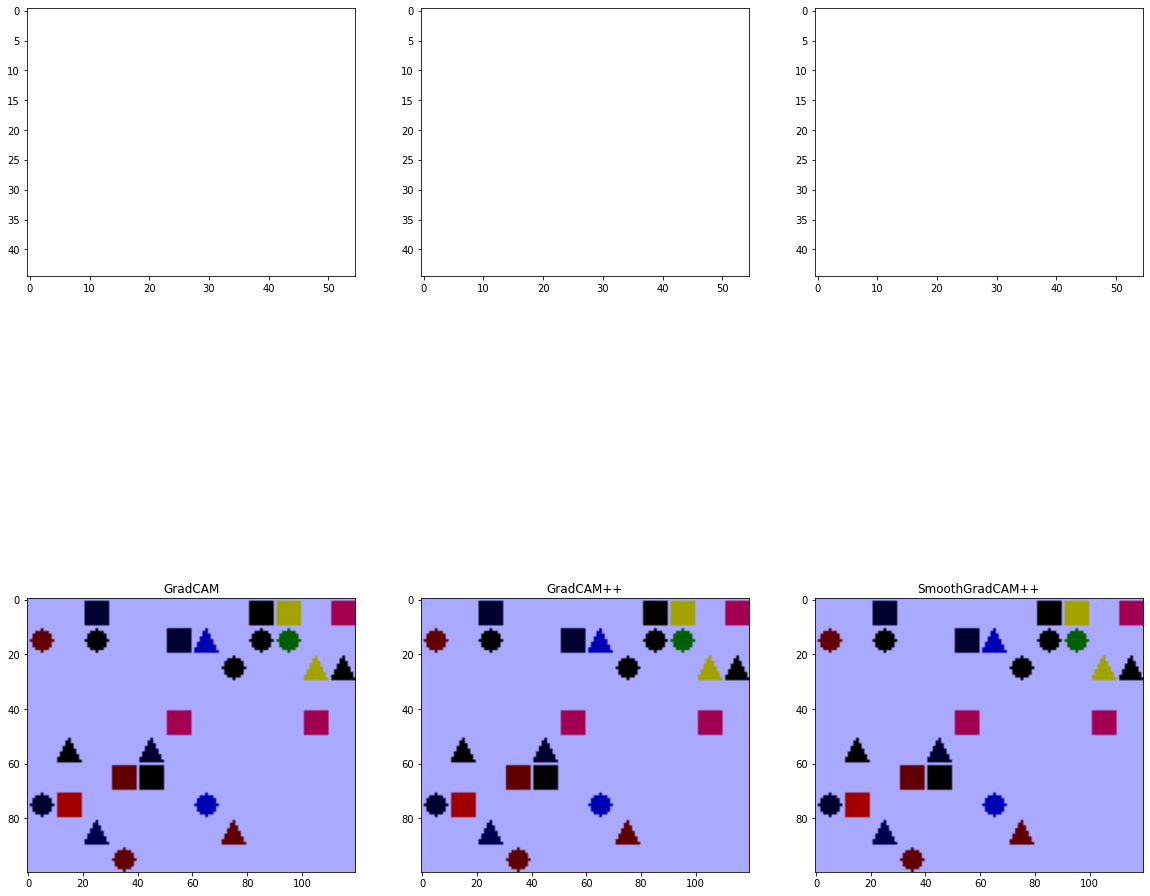

In [18]:
intp.smooth_exp(input2, image2, wrapped)

## Hierarchical Shapley

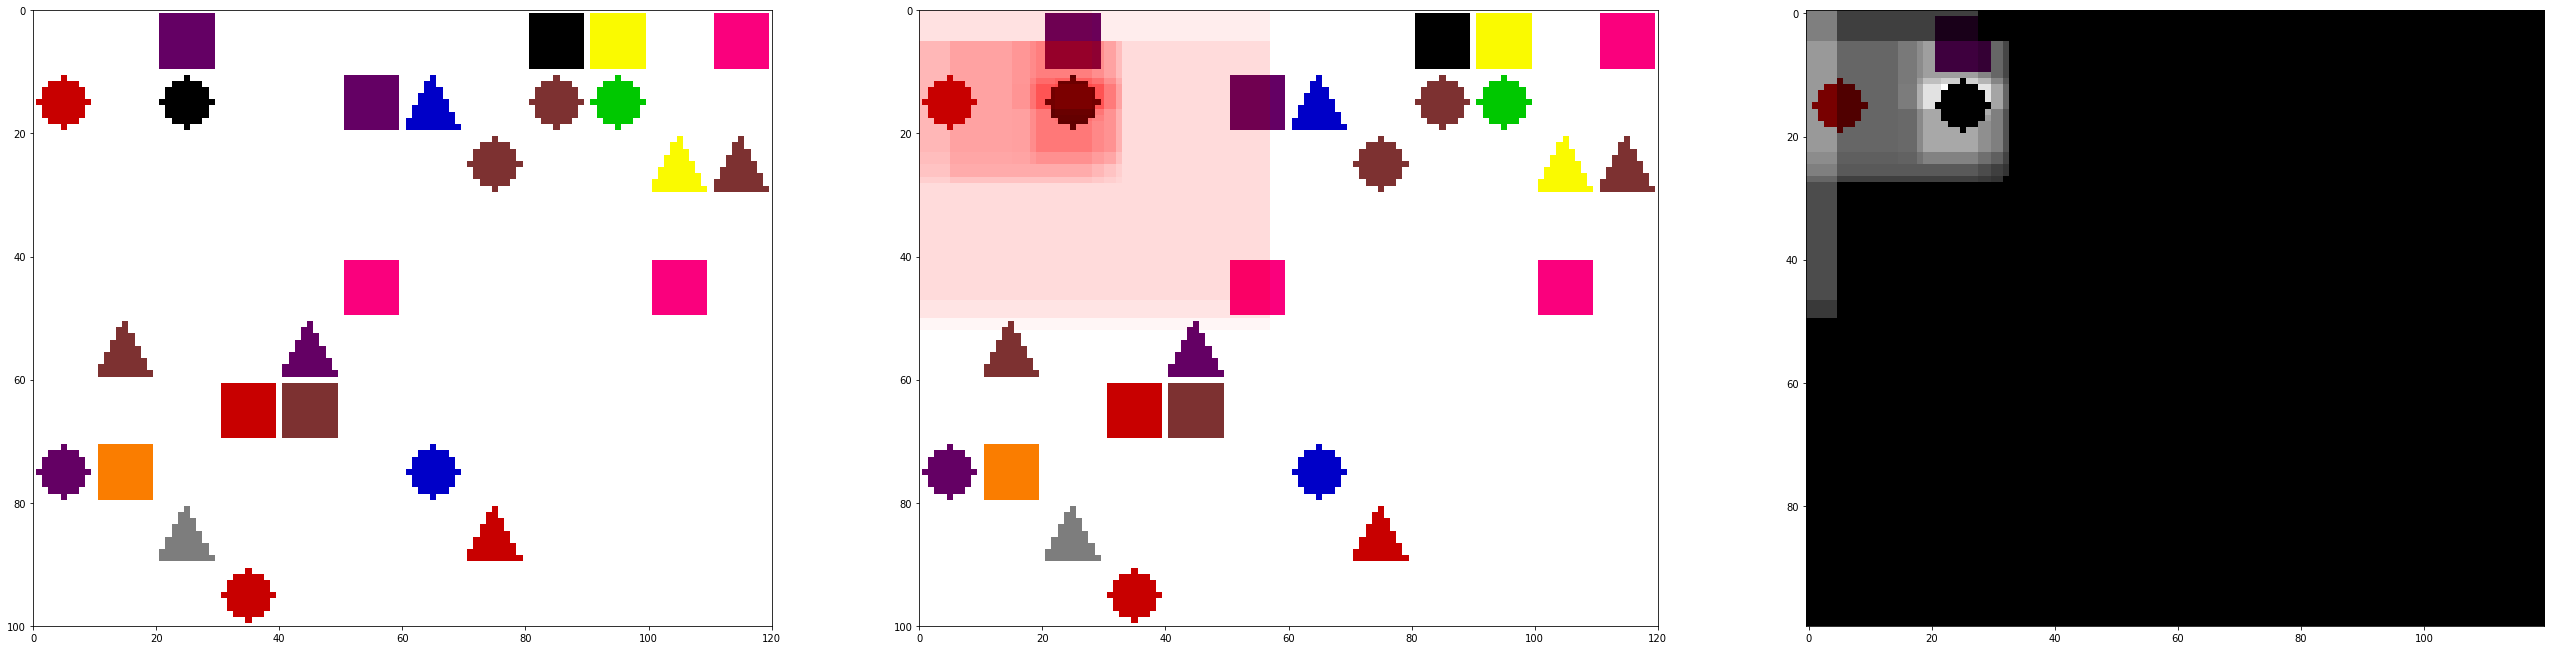

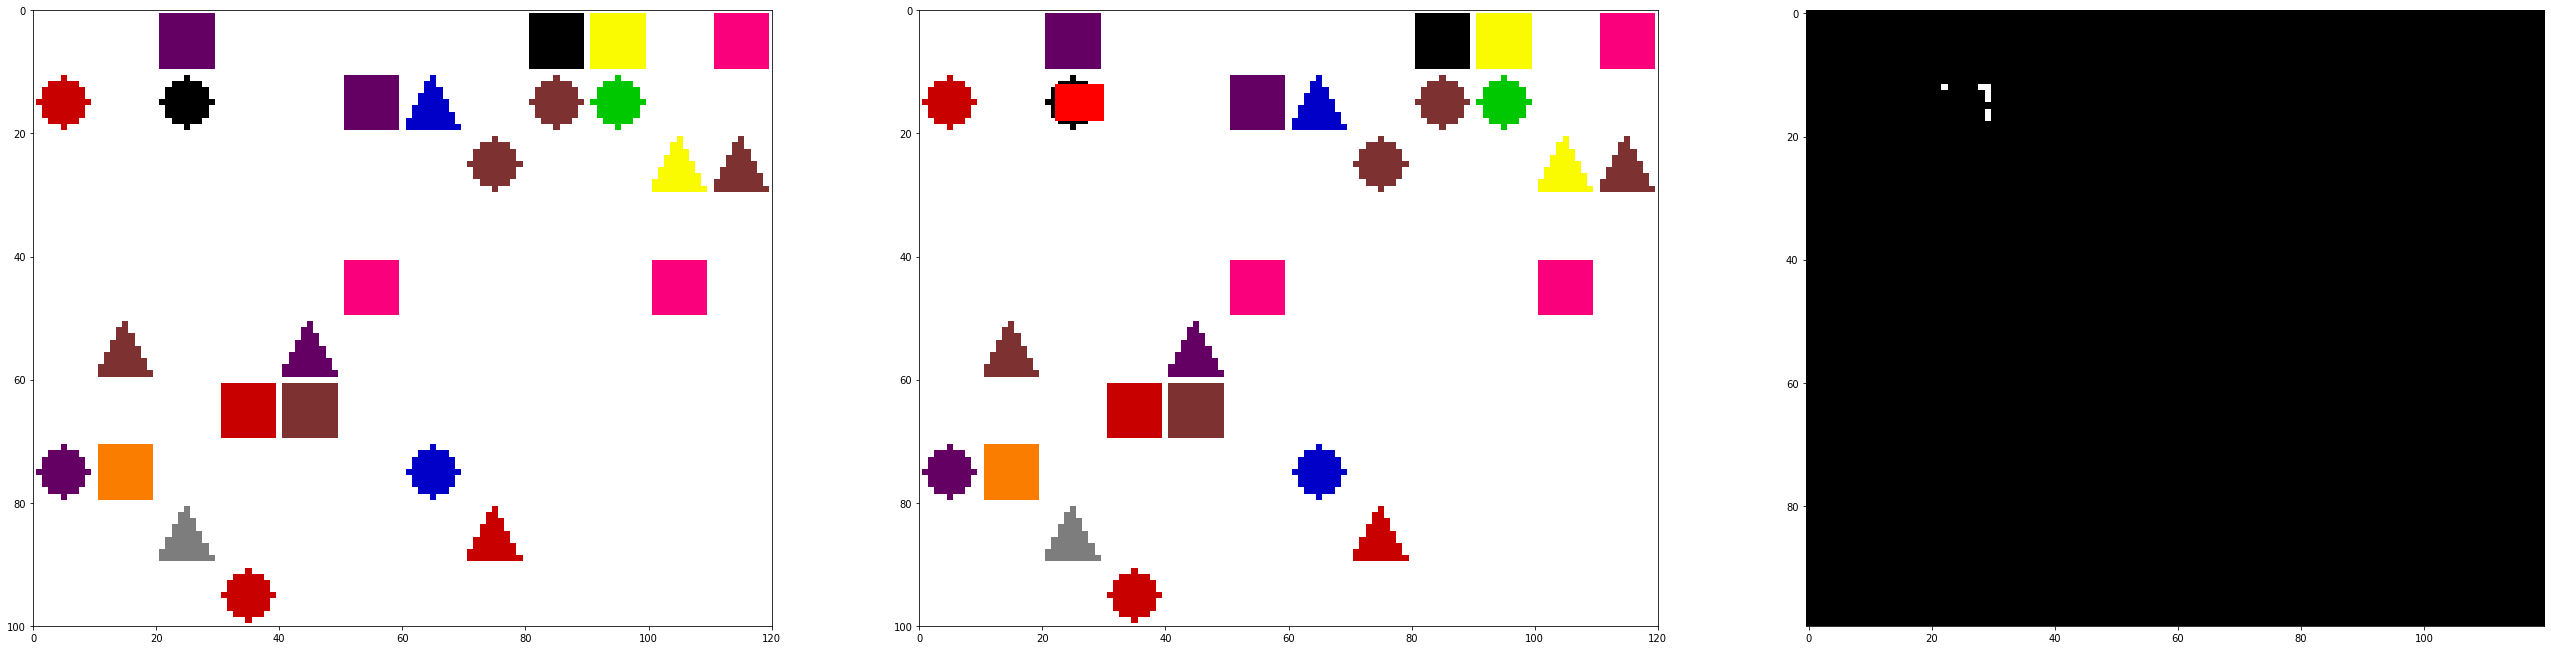

In [20]:
h.saliency_map(image2, label2, tolerance = [5,5.5,6,6.5,7], only_one_run = False);
h.saliency_map(image2, label2, tolerance = [6], only_one_run = True);